# E‑commerce A/B Test Hypotheses Prioritization & Analysis

## 📄 Project Description

This repository contains the end‑to‑end workflow for prioritizing marketing hypotheses, running an A/B test, and analyzing its results for a large online retailer.  

Key objectives:

1. **Hypotheses prioritization** based on expected impact and effort.  
2. **A/B test execution** to validate the top hypothesis.  
3. **Visualization** of cumulative revenue, average order size, and conversion rates per group.  
4. **Anomaly detection** in user order counts and order prices.  
5. **Statistical inference** on differences in conversion and order size, both on raw and filtered datasets.  
6. **Decision recommendation**: choose a winner group, stop test for no difference, or continue testing.

---

## 📈 Analyses & Visualizations

1. **Cumulative Revenue by Group**  
   - Plot of accumulated revenue over time for control (A) vs. variant (B).  
   - Conclusions & hypotheses on revenue trends.

2. **Cumulative Average Order Size by Group**  
   - Plot of average order value accumulation.  
   - Interpret differences and possible causes.

3. **Relative Difference in Cumulative Average Order Size (B vs. A)**  
   - Percentage gap chart.  
   - Insights on magnitude and stability of effect.

4. **Daily Conversion Rate per Group**  
   - Conversion = orders ÷ visits per day.  
   - Line chart comparison and descriptive conclusions.

5. **Scatter Plot: Number of Orders per User**  
   - Identify heavy purchasers vs. occasional buyers.  
   - Conclusions & detection of outliers.

6. **Order Count Anomaly Detection**  
   - 95th and 99th percentiles of orders per user.  
   - Thresholds beyond which an order count is considered anomalous.

7. **Scatter Plot: Order Prices**  
   - Distribution of individual order values.  
   - Conclusions on pricing behavior.

8. **Order Price Anomaly Detection**  
   - 95th and 99th percentiles of order price.  
   - Definition of anomalous order values.

9. **Statistical Significance Tests (Raw Data)**  
   - Conversion difference (two‑sample z‑test).  
   - Average order size difference (t‑test).

10. **Statistical Significance Tests (Filtered Data)**  
   - Repeat conversion and order size tests after excluding anomalies.

11. **Decision Making**  
   - Recommendation to:  
     1. Stop test and choose a leader.  
     2. Stop test—no significant difference.  
     3. Continue test for more data.

---

## Importing Libraries and Datasets

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from datetime import timedelta
from scipy.stats import mannwhitneyu
from statsmodels.stats.proportion import proportions_ztest

In [2]:
hypotheses = pd.read_csv('datasets/hypotheses_us.csv')
orders = pd.read_csv('datasets/orders_us.csv')
visits = pd.read_csv('datasets/visits_us.csv')

## Data Preprocessing and Cleaning

In [3]:
print(hypotheses.info())
hypotheses.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9 entries, 0 to 8
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Hypothesis  9 non-null      object
 1   Reach       9 non-null      int64 
 2   Impact      9 non-null      int64 
 3   Confidence  9 non-null      int64 
 4   Effort      9 non-null      int64 
dtypes: int64(4), object(1)
memory usage: 492.0+ bytes
None


,Hypothesis,Reach,Impact,Confidence,Effort
0,Add two new channels for attracting traffic. T...,3,10,8,6
1,Launch your own delivery service. This will sh...,2,5,4,10
2,Add product recommendation blocks to the store...,8,3,7,3
3,Change the category structure. This will incre...,8,3,3,8
4,Change the background color on the main page. ...,3,1,1,1


In [4]:
print(orders.info())
orders.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   transactionId  1197 non-null   int64  
 1   visitorId      1197 non-null   int64  
 2   date           1197 non-null   object 
 3   revenue        1197 non-null   float64
 4   group          1197 non-null   object 
dtypes: float64(1), int64(2), object(2)
memory usage: 46.9+ KB
None


,transactionId,visitorId,date,revenue,group
0,3667963787,3312258926,2019-08-15,30.4,B
1,2804400009,3642806036,2019-08-15,15.2,B
2,2961555356,4069496402,2019-08-15,10.2,A
3,3797467345,1196621759,2019-08-15,155.1,B
4,2282983706,2322279887,2019-08-15,40.5,B


In [5]:
#convert date columns to datetime
orders['date'] = pd.to_datetime(orders['date'])


In [6]:
# verify if there are any missing values or duplicates in the datasets
print(orders.isnull().sum())
print(orders.duplicated().sum())

transactionId    0
visitorId        0
date             0
revenue          0
group            0
dtype: int64
0


In [7]:
# verify if users are in both groups
grupo_por_usuario = orders.groupby('visitorId')['group'].nunique().reset_index()
print(grupo_por_usuario.head(5))
count = grupo_por_usuario[grupo_por_usuario==2].count()
print(count)

#we have 58 users that are in both groups, we will remove them from the dataset
usuarios_mix = grupo_por_usuario[grupo_por_usuario['group'] > 1]['visitorId']
orders = orders[~orders['visitorId'].isin(usuarios_mix)]
orders.info()

   visitorId  group
0    5114589      1
1    6958315      1
2    8300375      2
3   11685486      1
4   39475350      1
visitorId     0
group        58
dtype: int64
<class 'pandas.core.frame.DataFrame'>
Index: 1016 entries, 0 to 1196
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   transactionId  1016 non-null   int64         
 1   visitorId      1016 non-null   int64         
 2   date           1016 non-null   datetime64[ns]
 3   revenue        1016 non-null   float64       
 4   group          1016 non-null   object        
dtypes: datetime64[ns](1), float64(1), int64(2), object(1)
memory usage: 47.6+ KB


In [8]:
print(visits.info())
visits.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62 entries, 0 to 61
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   date    62 non-null     object
 1   group   62 non-null     object
 2   visits  62 non-null     int64 
dtypes: int64(1), object(2)
memory usage: 1.6+ KB
None


,date,group,visits
0,2019-08-01,A,719
1,2019-08-02,A,619
2,2019-08-03,A,507
3,2019-08-04,A,717
4,2019-08-05,A,756


In [ ]:
#convert date columns to datetime
visits['date'] = pd.to_datetime(visits['date'])

In [9]:
# verificar datos nulos y datos duplicados
print(visits.isnull().sum())
print(visits.duplicated().sum())

date      0
group     0
visits    0
dtype: int64
0


## Aanalyze hypotheses

### Prioritize hypotheses

**ICE** Method<br>
ICE: (Impact × Confidence) / Effort

In [10]:
hypotheses

,Hypothesis,Reach,Impact,Confidence,Effort
0,Add two new channels for attracting traffic. T...,3,10,8,6
1,Launch your own delivery service. This will sh...,2,5,4,10
2,Add product recommendation blocks to the store...,8,3,7,3
3,Change the category structure. This will incre...,8,3,3,8
4,Change the background color on the main page. ...,3,1,1,1
5,Add a customer review page. This will increase...,3,2,2,3
6,Show banners with current offers and sales on ...,5,3,8,3
7,Add a subscription form to all the main pages....,10,7,8,5
8,Launch a promotion that gives users discounts ...,1,9,9,5


In [11]:
hypotheses['ICE'] = (hypotheses['Impact'] * hypotheses['Confidence']) / hypotheses['Effort']
ICE = hypotheses[['Hypothesis', 'ICE']].sort_values(by='ICE', ascending=False).round(1)
ICE

,Hypothesis,ICE
8,Launch a promotion that gives users discounts ...,16.2
0,Add two new channels for attracting traffic. T...,13.3
7,Add a subscription form to all the main pages....,11.2
6,Show banners with current offers and sales on ...,8.0
2,Add product recommendation blocks to the store...,7.0
1,Launch your own delivery service. This will sh...,2.0
5,Add a customer review page. This will increase...,1.3
3,Change the category structure. This will incre...,1.1
4,Change the background color on the main page. ...,1.0


**RICE** Method<br>
ICE: (Reach * Impact × Confidence) / Effort

In [12]:
hypotheses['RICE'] = (hypotheses['Reach'] * hypotheses['Impact'] * hypotheses['Confidence']) / hypotheses['Effort']
RICE = hypotheses[['Hypothesis', 'RICE']].sort_values(by='RICE', ascending=False)
RICE

,Hypothesis,RICE
7,Add a subscription form to all the main pages....,112.0
2,Add product recommendation blocks to the store...,56.0
0,Add two new channels for attracting traffic. T...,40.0
6,Show banners with current offers and sales on ...,40.0
8,Launch a promotion that gives users discounts ...,16.2
3,Change the category structure. This will incre...,9.0
1,Launch your own delivery service. This will sh...,4.0
5,Add a customer review page. This will increase...,4.0
4,Change the background color on the main page. ...,3.0


## A/B Test Analysis

### 1.- Accumulated income by group.

In [35]:
orders

,transactionId,visitorId,date,revenue,group
0,3667963787,3312258926,2019-08-15,30.4,B
1,2804400009,3642806036,2019-08-15,15.2,B
3,3797467345,1196621759,2019-08-15,155.1,B
4,2282983706,2322279887,2019-08-15,40.5,B
5,182168103,935554773,2019-08-15,35.0,B
...,...,...,...,...,...
1191,3592955527,608641596,2019-08-14,255.7,B
1192,2662137336,3733762160,2019-08-14,100.8,B
1193,2203539145,370388673,2019-08-14,50.1,A
1194,1807773912,573423106,2019-08-14,165.3,A


In [ ]:
# Calculate cumulative revenue by group and date
cumulative_revenue = (orders.groupby(['group', 'date'])['revenue']
                    .sum()
                    .groupby(level=0)
                    .cumsum()
                    .reset_index())
display(cumulative_revenue)



,group,date,revenue
0,A,2019-08-01,2266.6
1,A,2019-08-02,3734.9
2,A,2019-08-03,5550.1
3,A,2019-08-04,6225.6
4,A,2019-08-05,7623.6
...,...,...,...
57,B,2019-08-27,71885.0
58,B,2019-08-28,72895.5
59,B,2019-08-29,74576.7
60,B,2019-08-30,77863.5


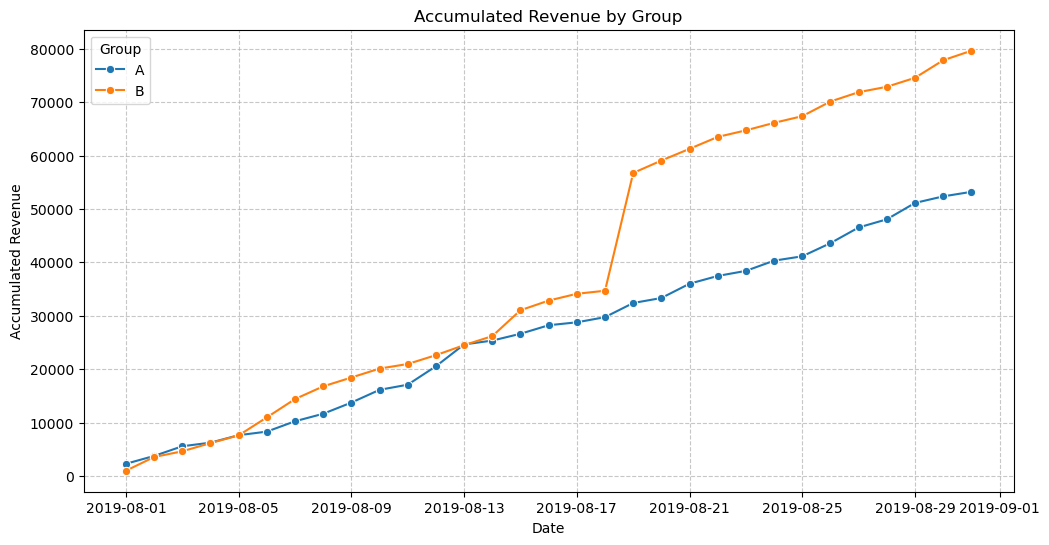

In [37]:
plt.figure(figsize=(12, 6))
sns.lineplot(
    data=cumulative_revenue,
    x="date",
    y="revenue",
    hue="group",
    marker="o"  
)

plt.title("Accumulated Revenue by Group")
plt.xlabel("Date")
plt.ylabel("Accumulated Revenue")
plt.grid(True, linestyle="--", alpha=0.7)
plt.legend(title="Group")
plt.show()

**Conclusions** <br>
Both groups start with similar trends, but around August 20th, Group B shows a noticeably steeper upward slope. This suggests a potential impactful change — such as a successful promotion or marketing campaign — that significantly boosted performance for Group B. Alternatively, this shift may be influenced by outliers or anomalies, which should be examined further in the analysis.


### 2.- Cumulative Average Order Size by Group

In [ ]:
# Calculate cumulative orders by group and date
cumulative_orders = (
    orders.groupby(['group', 'date'])
    .agg(total_revenue=('revenue', 'sum'), total_orders=('transactionId', 'count'))
    .groupby(level=0)
    .cumsum()
    .reset_index()
)
cumulative_orders['average_order_size'] = cumulative_orders['total_revenue'] / cumulative_orders['total_orders']


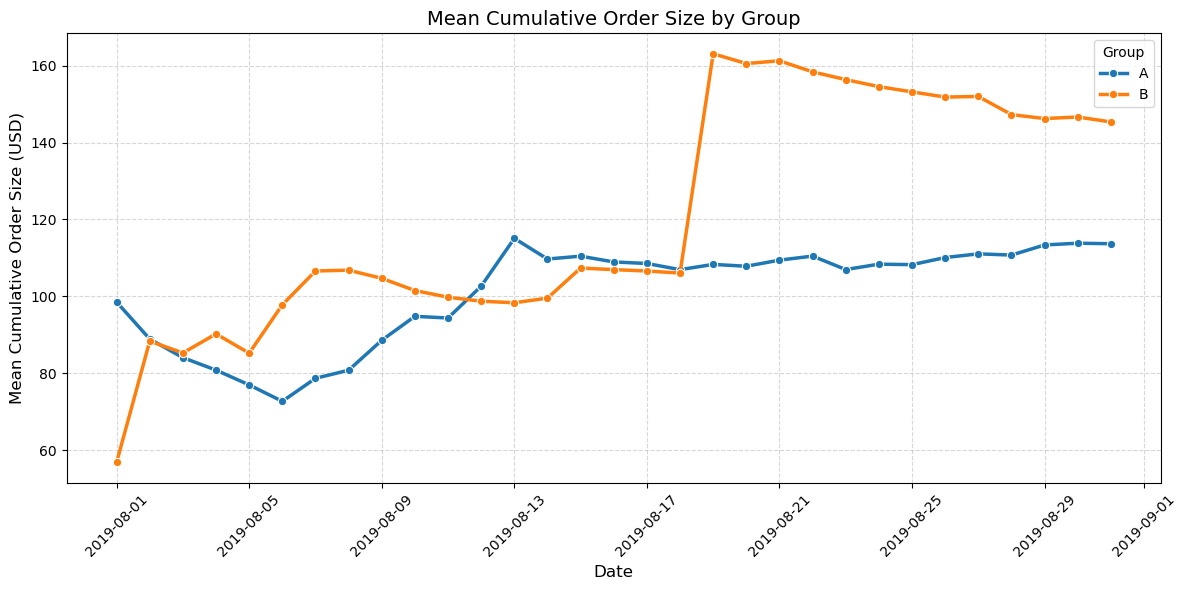

In [ ]:
plt.figure(figsize=(12, 6))
sns.lineplot(
    data=cumulative_orders,
    x="date",
    y="average_order_size",
    hue="group",
    marker="o",
    linewidth=2.5
)

plt.title("Mean Cumulative Order Size by Group", fontsize=14)
plt.xlabel("Date", fontsize=12)
plt.ylabel("Mean Cumulative Order Size (USD)", fontsize=12)
plt.grid(True, linestyle="--", alpha=0.5)
plt.legend(title="Group")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

**Conclusions** <br>
Initially, the two groups start with a noticeable gap, with Group B clearly outperforming. This indicates a higher cumulative average for Group B during the early days. While Group A gradually increases, it eventually stabilizes. In contrast, Group B experiences a sharp spike around August 20th, followed by a gradual decline. Despite the drop, Group B ends the period with a strong lead over Group A. This suggests that the spike had a significant impact — potentially due to a successful marketing campaign, a special discount, or even an outlier that should be further investigated.

### 3.- Relative Difference in Cumulative Average Order Size (B vs. A)

In [ ]:
group_a = cumulative_orders[cumulative_orders["group"] == "A"][["date", "average_order_size"]]
group_b = cumulative_orders[cumulative_orders["group"] == "B"][["date", "average_order_size"]]

comparison = pd.merge(
    group_a.rename(columns={"average_order_size": "avg_A"}),
    group_b.rename(columns={"average_order_size": "avg_B"}),
    on="date",
    how="outer"
)

comparison["relative_diff"] = ((comparison["avg_B"] - comparison["avg_A"]) / comparison["avg_A"]) * 100
comparison.head()

,date,avg_A,avg_B,relative_diff
0,2019-08-01,98.547826,56.894118,-42.267506
1,2019-08-02,88.926190,88.382500,-0.611395
2,2019-08-03,84.092424,85.312963,1.451425
3,2019-08-04,80.851948,90.272059,11.651062
4,2019-08-05,77.006061,85.256180,10.713597


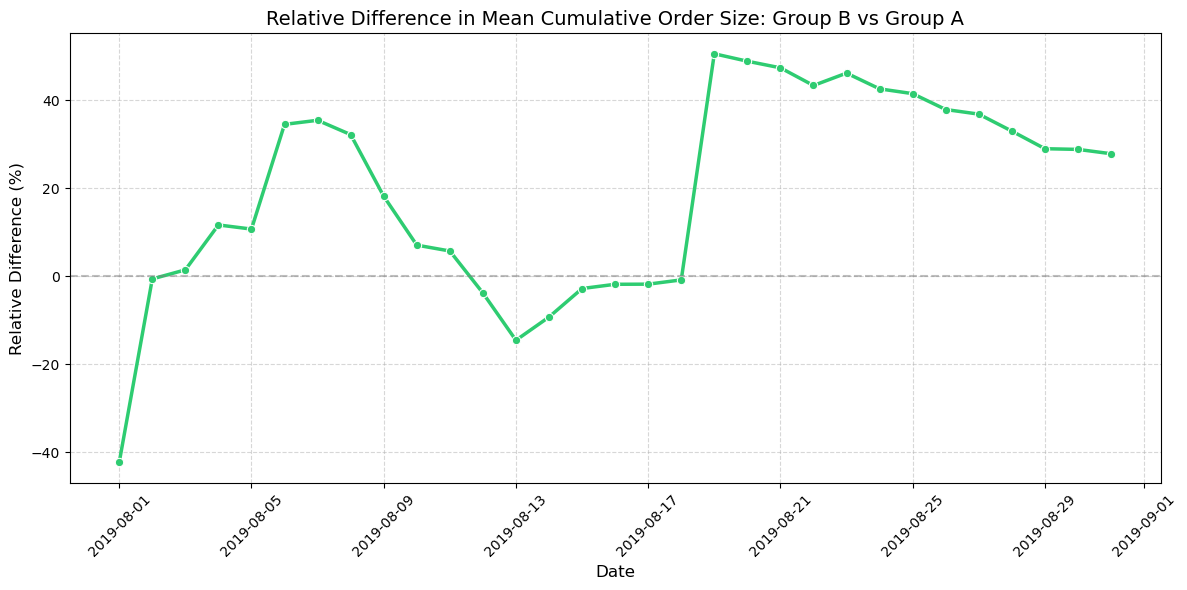

In [40]:
plt.figure(figsize=(12, 6))
sns.lineplot(
    data=comparison,
    x="date",
    y="relative_diff",
    color="#2ecc71",  
    marker="o",
    linewidth=2.5
)


plt.axhline(0, color="gray", linestyle="--", alpha=0.5)

plt.title("Relative Difference in Mean Cumulative Order Size: Group B vs Group A", fontsize=14)
plt.xlabel("Date", fontsize=12)
plt.ylabel("Relative Difference (%)", fontsize=12)
plt.grid(True, linestyle="--", alpha=0.5)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

**Conclusions** <br>
Analyzing the graph, we observe that Group B consistently outperforms Group A in terms of cumulative average order value. The largest gap appears around August 20th — similar to other metrics — where the difference reaches nearly 50%, marking the peak advantage of Group B. This further reinforces the conclusion that Group B significantly outperforms Group A throughout the period.

### 4.- Daily Conversion Rate per Group

In [ ]:
# unique orders per day and group
ordenes_unicas_dia_grupo = (
    orders[['date','group','transactionId']]
    .sort_values(by='date',ascending=True)
    .groupby(['date','group'])
    .nunique()
    .reset_index()
    .rename(columns={'transactionId':'ordenes_diarias'})
    
)

ordenes_acumuladas = (
    ordenes_unicas_dia_grupo
    .groupby('group')[['date','group','ordenes_diarias']]
    .apply(lambda x: x.sort_values('date').assign(ordenes_acumuladas=lambda x: x['ordenes_diarias'].cumsum()))
    .reset_index(drop=True)
)

# acumulative visits by group and date
visitas_acumuladas = (
    visits
    .sort_values(['group', 'date'])  
    .groupby('group', group_keys=False)  
    .apply(lambda x: x.assign(visitas_acumuladas=x['visits'].cumsum()))
    [['date', 'group', 'visitas_acumuladas']]
)

#merge cumulative orders and visits
merged_data = ordenes_acumuladas.merge(
    visitas_acumuladas,
    on=['date','group'],
    how='inner'
)

merged_data['conversion_rate'] = merged_data['ordenes_acumuladas'] / merged_data['visitas_acumuladas']

merged_data


/var/folders/j_/7ll1w8n13nq1q1p7bf8pyjj00000gn/T/ipykernel_72661/3918772380.py:24: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: x.assign(visitas_acumuladas=x['visits'].cumsum()))


,date,group,ordenes_diarias,ordenes_acumuladas,visitas_acumuladas,conversion_rate
0,2019-08-01,A,23,23,719,0.031989
1,2019-08-02,A,19,42,1338,0.031390
2,2019-08-03,A,24,66,1845,0.035772
3,2019-08-04,A,11,77,2562,0.030055
4,2019-08-05,A,22,99,3318,0.029837
...,...,...,...,...,...,...
57,2019-08-27,B,11,473,16523,0.028627
58,2019-08-28,B,22,495,17177,0.028818
59,2019-08-29,B,15,510,17708,0.028801
60,2019-08-30,B,21,531,18198,0.029179


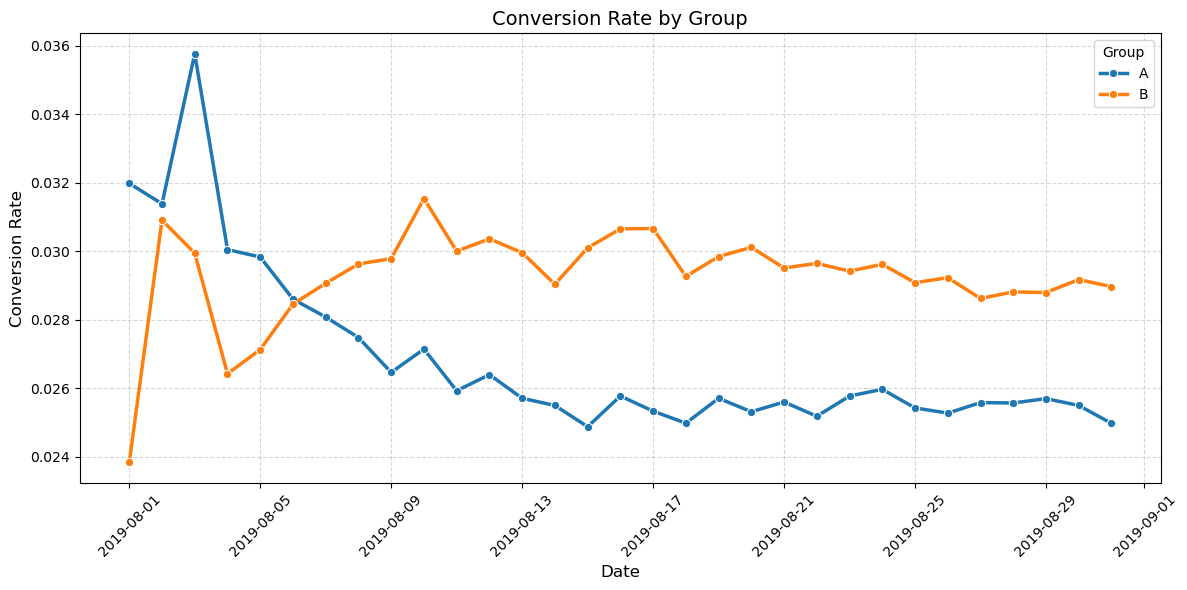

In [41]:
plt.figure(figsize=(12, 6))
sns.lineplot(
    data=merged_data,
    x="date",
    y="conversion_rate",
    hue="group",
    marker="o",
    linewidth=2.5
)

plt.title("Conversion Rate by Group", fontsize=14)
plt.xlabel("Date", fontsize=12)
plt.ylabel("Conversion Rate", fontsize=12)
plt.grid(True, linestyle="--", alpha=0.5)
plt.legend(title="Group")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

**Conclusions** <br>
When analyzing the cumulative data, it becomes evident that Group B achieves a higher conversion rate compared to Group A. Although Group A initially leads, Group B surpasses it after a few days and maintains the lead throughout the rest of the period.

### 5.- Scatter Plot: Number of Orders per User

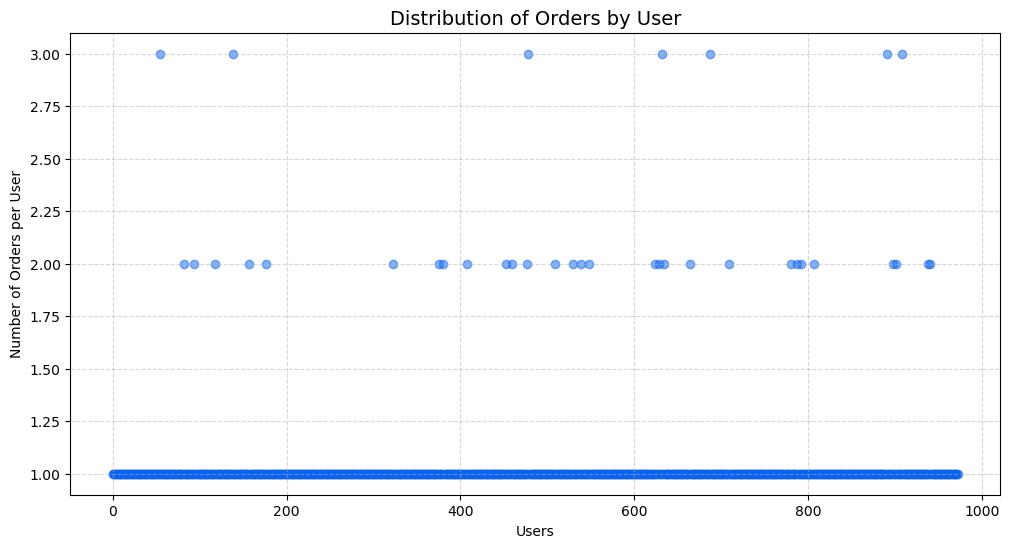

In [43]:
# group by user and count orders
orders_per_user = (
    orders.groupby("visitorId")["transactionId"]
    .count()
    .reset_index()
    .rename(columns={"transactionId": "total_orders"})
)

plt.figure(figsize=(12, 6))
plt.scatter(
    x=range(len(orders_per_user)),  
    y=orders_per_user["total_orders"],
    alpha=0.5,  
    color="#0a63f0"
)

plt.title("Distribution of Orders by User", fontsize=14)
plt.xlabel("Users")
plt.ylabel("Number of Orders per User")
plt.grid(True, linestyle="--", alpha=0.5)

**Conclusions** <br>
Most users placed only one order, with very few making two — these can be considered returning users. Only seven users placed three orders, potentially indicating the most loyal customers. Interestingly, there are no outliers in the data, which is a positive sign suggesting there were no errors or fraudulent orders.

### 6.- Order Count Anomaly Detection

In [44]:
print('Percentiles 90/95/99:', np.percentile(orders_per_user["total_orders"], [90, 95, 99]))

Percentiles 90/95/99: [1. 1. 2.]


**Conclusions** <br>
As we see in the graph above, a little less than 1% make greater than or equal to 2 orders.

### 7.- Scatter Plot: Order Prices

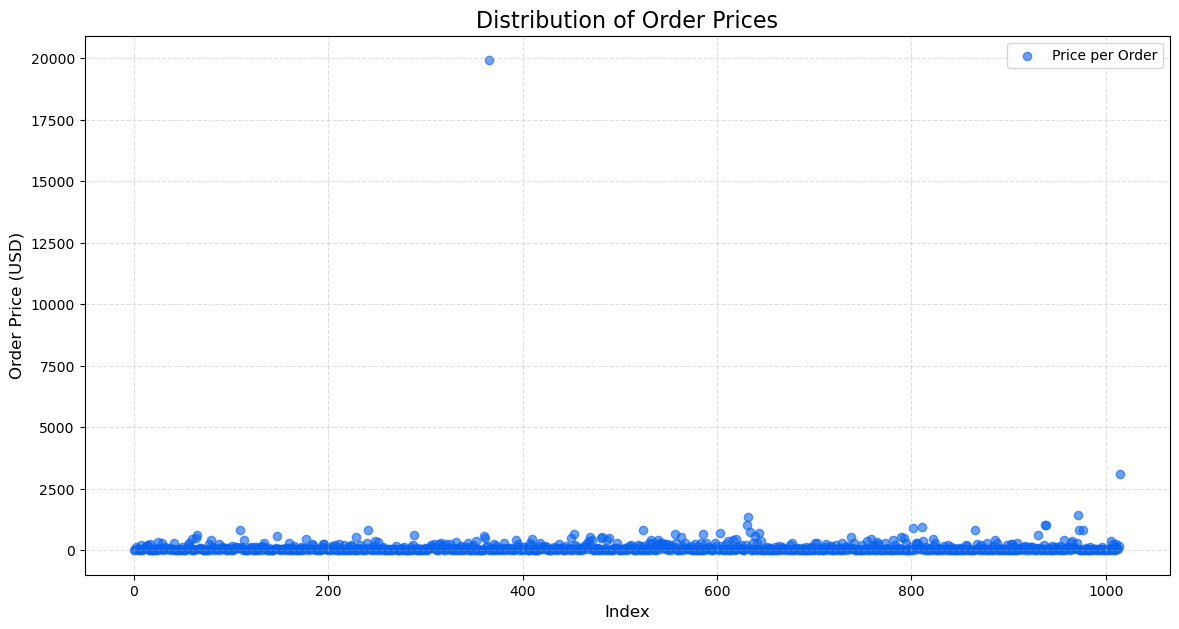

In [45]:
plt.figure(figsize=(14, 7))
plt.scatter(
    x= range(len(orders["revenue"])),
    y=orders["revenue"],
    alpha=0.6,        
    color="#0a63f0",  
    label="Price per Order"
)


plt.title("Distribution of Order Prices", fontsize=16)
plt.xlabel("Index", fontsize=12)
plt.ylabel("Order Price (USD)", fontsize=12)
plt.grid(True, linestyle="--", alpha=0.4)
plt.legend()
plt.show()

**Conclusions** <br>
Most orders do not exceed 1000 dollars, which is fine, but we can see that there are two specific atypical orders, one above 2500 and one already at 20000, which is extremely atypical and something that had not been seen before. We need to see the perentiles to know how the orders are really distributed.

### 8.- Order Price Anomaly Detection

In [46]:
print('Percentiles 90/95/99:', np.percentile(orders["revenue"], [90, 95, 99]))

Percentiles 90/95/99: [280.8   414.275 830.3  ]


**Conclusions** <br> 
It is confirmed that 95% of orders do not exceed $415 per order, the point where it becomes an anomaly would be orders above $830, which less than 1% of the data meets.

### 9.- Statistical Significance Tests (Raw Data)

In [47]:
# Calculate total visits and conversions by group
visits_total = visits.groupby('group')['visits'].sum()
# Calculate total conversions by group
conversions_total = orders.groupby('group')['transactionId'].nunique()

summary = pd.DataFrame({
    'visits_total': visits_total,
    'conversions': conversions_total
})

# Calculate conversion rate
summary['conversion_rate'] = summary['conversions'] / summary['visits_total']
display(summary)

,visits_total,conversions,conversion_rate
group,,,
A,18736,468,0.024979
B,18916,548,0.028970


In [49]:
conversions = summary['conversions'].values
visits_values = summary['visits_total'].values
z_stat, p_val = proportions_ztest(conversions, visits_values)

print(f"Z-stat: {z_stat:.4f}")
print(f"P-value: {p_val:.4f}")

alpha = 0.05 

if p_val > alpha:
    print(f"There is no significant difference (p = {p_val:.4f})")
    print("We cannot conclude that one group converts better than the other.")
else:
    print(f"Significant difference (p = {p_val:.4f})")
    print("There is statistical evidence that one group has better conversion.")

Z-stat: -2.3899
P-value: 0.0169
Significant difference (p = 0.0169)
There is statistical evidence that one group has better conversion.


**Conclusions** <br> 
 Since the z-value is negative, this indicates that group B has a better conversion rate, and since the p-value is less than alpha, this means that there is a group that clearly has a better conversion, in this case group B.

In [50]:
group_A = orders[orders['group'] == 'A']['revenue']
group_B = orders[orders['group'] == 'B']['revenue']

# Apply robust Mann-Whitney U test
u_stat, pval_rev = stats.mannwhitneyu(group_A, group_B, alternative='two-sided')
print(f"U-stat: {u_stat}")
print(f"P-value: {pval_rev:.4f}")

alpha = 0.05

if pval_rev > alpha:
    print("There is no significant difference in average order size.")
else:
    print("There is a significant difference in average order size.")

U-stat: 129041.5
P-value: 0.8622
There is no significant difference in average order size.


**Conclusions** <br> 
Seeing that there is no significant difference in the average order, this suggests that both groups spend approximately the same when purchasing, but if we take the data that group B has better conversion, it is still ahead.


### 11.- Statistical Significance Tests (Filtered Data) 

In [51]:
revenue_threshold = orders['revenue'].quantile(.98).round(2)
print(revenue_threshold)
# Filter DataFrame
filtered_orders = orders[orders['revenue'] <= revenue_threshold]
# Group to count filtered conversions
filtered_conversions = filtered_orders.groupby('group')['transactionId'].nunique()
filtered_summary = pd.DataFrame({
    'visits_total': visits_total,
    'conversions': filtered_conversions
})
# Calculate conversion rate
filtered_summary['conversion_rate'] = filtered_summary['conversions'] / filtered_summary['visits_total']
print(filtered_summary)

654.56
       visits_total  conversions  conversion_rate
group                                            
A             18736          454         0.024231
B             18916          541         0.028600


In [52]:
# We apply the same test but now with the filtered df
conversions = filtered_summary['conversions'].values
visits_values = filtered_summary['visits_total'].values
z_stat, p_val = proportions_ztest(conversions, visits_values)

print(f"Z-stat: {z_stat:.4f}")
print(f"P-value: {p_val:.4f}")

alpha = 0.05 

if p_val > alpha:
    print(f"There is no significant difference (p = {p_val:.4f})")
    print("We cannot conclude that one group converts better than the other.")
else:
    print(f"Significant difference (p = {p_val:.4f})")
    print("There is statistical evidence that one group has better conversion.")

Z-stat: -2.6425
P-value: 0.0082
Significant difference (p = 0.0082)
There is statistical evidence that one group has better conversion.


**Conclusion** <br> 
When filtering the df we realize that there was not that much difference, since the atypical values were very few, seeing that the p-value is less than alpha and without atypical values, we can conclude with more certainty that B has a better conversion than A

In [53]:
group_A = filtered_orders[filtered_orders['group'] == 'A']['revenue']
group_B = filtered_orders[filtered_orders['group'] == 'B']['revenue']

# Apply robust Mann-Whitney U test
u_stat, p_value = stats.mannwhitneyu(group_A, group_B, alternative='two-sided')
print(f"U-stat: {u_stat}")
print(f"P-value: {p_value:.4f}")

alpha = 0.05
if p_value > alpha:
    print("There is no significant difference in average order size.")
else:
    print("There is a significant difference in average order size.")

U-stat: 121437.0
P-value: 0.7616
There is no significant difference in average order size.


**conclusion**<br>
Once again, with the leaked data, there is not enough statistical evidence to affirm that there is a difference in the average order size between groups A and B. However, seeing that B has a better conversion, it continues ahead.

## Conclusion


On one hand, the conversion test showed that Group B performs **significantly** better in terms of conversion rate. On the other hand, there is no statistically significant difference in average order value between the groups. This indicates that Group B converts better without compromising the value per transaction. Therefore, it is recommended to stop the test and adopt Group B as the winning variant.